In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from natsort import natsorted, ns
from functools import reduce

In [2]:
n_revision_list = []
max_nodes_list = []
coeff_var_list = []
rev_weight_diff_list = []
addition_deletion_list = []
max_depth_list = []

In [3]:
root_paths = ['/home/eduardo/Desktop/new_datasets/converted/converted_1',
              '/home/eduardo/Desktop/new_datasets/converted/converted_5',
              '/home/eduardo/Desktop/new_datasets/converted/converted_3',
              '/home/eduardo/Desktop/new_datasets/converted/converted_2',
              '/home/eduardo/Desktop/new_datasets/converted/converted_4',
              '/home/eduardo/Desktop/new_datasets/OLD']

dataset_paths = []
for rp in root_paths:
    only_files = [os.path.join(rp,f) for f in os.listdir(rp) if os.path.isfile(os.path.join(rp, f))]
    dataset_paths.extend(only_files)

print(len(dataset_paths))    

# Remove this line later after testing results
# dataset_paths = dataset_paths[:100]

1506


In [4]:
n_datasets = len(dataset_paths) - 1
for csv_path in dataset_paths:
    print(str(n_datasets) + '    ', end='\r', flush=True)
    n_datasets -= 1
    # Read csv
    try:
        df = pd.read_csv(csv_path, header=None)
    except:
        print('Error with ' + csv_path)
        
    # Remove non-leaf rows
    df = df[~df[0].isin(df[1])]
    # Remove implicit parent info
    df.drop(1, axis=1, inplace=True)
    # Set first col as index
    df.set_index(df.columns[0], inplace=True)
    # Rename columns
    df.columns = range(df.shape[1])
    # Replace 0s with NaN
    df.replace({0:np.nan}, inplace=True)
    # Normalize each column of table
    for column in df.columns:
        df[column] = df[column] / df[column].sum()

    # Count revisions
    n_revisions = len(df.columns)
    n_revision_list.append(n_revisions)

    # Max number of leafs in a revision
    max_nodes = df.notnull().sum(axis=0).max()
    max_nodes_list.append(max_nodes)
    
    # Find max tree depth
    max_depth = max([str(i).count('/') for i in df.index])
    max_depth_list.append(max_depth)
    
    # Compute coefficient of variance
    var_coeff = df.unstack().std() / df.unstack().mean()
    coeff_var_list.append(var_coeff)

    # Count additions and deletions proportion (no distinction between the two)
    for i in range(n_revisions - 1):
        addition_deletion_ratio = np.logical_xor(df.iloc[:, i].notnull(), df.iloc[:, i + 1].notnull()).sum() / (df.iloc[:, i].notnull().sum() + 1)
        addition_deletion_list.append(addition_deletion_ratio)

    # Compute cell diff between consecutive revisions
    df = df.fillna(0)
    diffs_df = np.absolute(np.diff(df.values, axis=1))
    diffs_per_rev = pd.DataFrame(diffs_df).sum(axis=0).tolist()
    rev_weight_diff_list.extend(diffs_per_rev)

/home/eduardo/Desktop/new_datasets/converted/converted_3/wb-DT.NFL.NEBR.CD.data


In [5]:
# print(n_revision_list)
# print(max_nodes_list)
# print(coeff_var_list)
# print(rev_weight_diff_list)
# print(addition_deletion_list)

In [6]:
def array_statistics(ar):
    ds = stats.describe(ar)
    print('Mean: %.4f' % ds.mean, end='   ')
    print('Min/Max: %.4f/%.4f' % ds.minmax, end='   ')
    print('Variance: %.4f' % ds.variance)
    qt = np.percentile(ar, [25, 50, 75])
    print('1st Quartile: %.4f' % qt[0], end='     ')
    print('Median: %.4f' % qt[1], end='     ')
    print('3rd Quartile: %.4f' % qt[2])

Mean: 49.7311   Min/Max: 5.0000/468.0000   Variance: 1653.3569
1st Quartile: 28.0000     Median: 47.0000     3rd Quartile: 57.0000


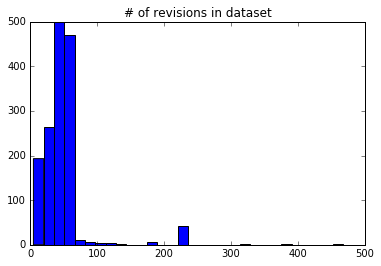

In [7]:
plt.hist(n_revision_list, bins=30);
plt.title('# of revisions in dataset')
array_statistics(n_revision_list)

Mean: 347.7351   Min/Max: 1.0000/20614.0000   Variance: 947640.3796
1st Quartile: 115.0000     Median: 163.0000     3rd Quartile: 194.0000


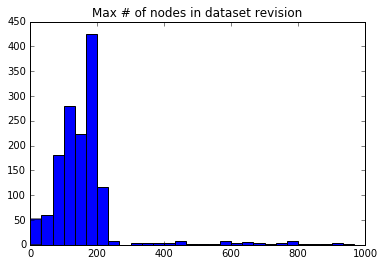

In [8]:
plt.hist(max_nodes_list, bins=30, range=[0,1000])
plt.title('Max # of nodes in dataset revision')
array_statistics(max_nodes_list)

Mean: 2.7696   Min/Max: 0.0000/19.0000   Variance: 5.2392
1st Quartile: 2.0000     Median: 2.0000     3rd Quartile: 2.0000


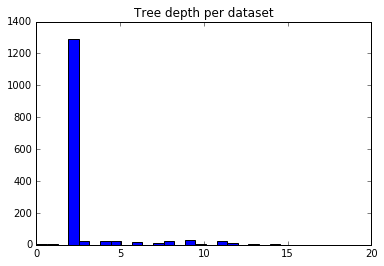

In [14]:
plt.hist(max_depth_list, bins=30)
plt.title('Tree depth per dataset')
array_statistics(max_depth_list)

Mean: 0.3098   Min/Max: 0.0000/2.0000   Variance: 0.1334
1st Quartile: 0.0498     Median: 0.1914     3rd Quartile: 0.4387


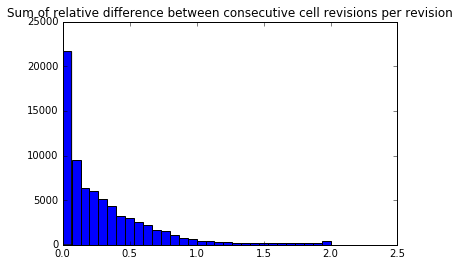

In [10]:
plt.hist(rev_weight_diff_list, bins=30)
plt.title('Sum of relative difference between consecutive cell revisions per revision')
array_statistics(rev_weight_diff_list)

Mean: 0.3060   Min/Max: 0.0000/1023.0000   Variance: 45.0996
1st Quartile: 0.0027     Median: 0.0432     3rd Quartile: 0.2168


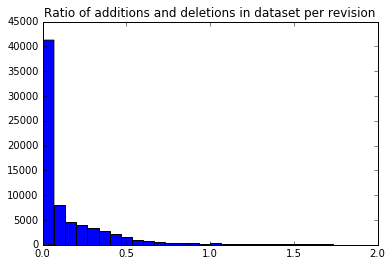

In [11]:
plt.hist(addition_deletion_list, bins=30, range=[0,2])
plt.title('Ratio of additions and deletions in dataset per revision')
array_statistics(addition_deletion_list)

Mean: 2.3317   Min/Max: 0.0000/16.7903   Variance: 3.7219
1st Quartile: 0.9684     Median: 1.8977     3rd Quartile: 3.1125


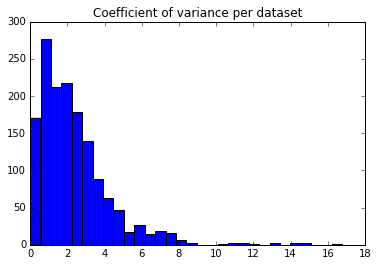

In [12]:
plt.hist(coeff_var_list, bins=30)
plt.title('Coefficient of variance per dataset')
array_statistics(coeff_var_list)

In [13]:
np.savetxt('n_revision_list.csv', n_revision_list, delimiter=',')
np.savetxt('max_nodes_list.csv', max_nodes_list, delimiter=',')
np.savetxt('coeff_var_list.csv', coeff_var_list, delimiter=',')
np.savetxt('rev_weight_diff_list.csv', rev_weight_diff_list, delimiter=',')
np.savetxt('addition_deletion_list.csv', addition_deletion_list, delimiter=',')
np.savetxt('max_depth_list.csv', max_depth_list, delimiter=',')

# print(n_revision_list)
# print(max_nodes_list)
# print(coeff_var_list)
# print(rev_weight_diff_list)
# print(addition_deletion_list)